# Setup

## Imports

In [1]:
from vaiutils import path_consts
from os.path import exists
from csv import writer as CSVWriter

Import Keras modules including ResNet

In [2]:
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Set up data and useful variables

In [3]:
for k, v in path_consts('CatDog-Resnet', 'CatDog'):
    exec(k + '=v')

In [4]:
use_sample = False
if use_sample:
    DIR_TRAIN = DIR_DATA + '/sample/train'
    DIR_TEST = DIR_DATA + '/sample/test'
    DIR_VALID = DIR_DATA + '/sample/valid'
    DIR_RESULTS = DIR_DATA + '/sample/results'
else:
    DIR_TRAIN = DIR_DATA + '/train'
    DIR_TEST = DIR_DATA + '/test'
    DIR_VALID = DIR_DATA + '/valid'
    DIR_RESULTS = DIR_DATA + '/results'

# ResNet Precomputed Activations

## Create Resnet Model

In [78]:
clear_session()
resnet = ResNet50(include_top=False, input_shape=(400, 400, 3), pooling='avg')
resnet.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, 400, 400, 3)        0                                                     
________________________________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D)       (None, 406, 406, 3)        0             input_1[0][0]                           
________________________________________________________________________________________________________________________
conv1 (Conv2D)                         (None, 200, 200, 64)       9472          zero_padding2d_1[0][0]                  
________________________________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   

## Precompute features

Helper function to preprocess images for ResNet
(see keras.applications.resnet50.preprocess_input)

In [79]:
def preprocess_image(x):
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

Create batches from directories

In [80]:
generator = ImageDataGenerator(preprocessing_function=preprocess_image)
train_batches = generator.flow_from_directory(
    DIR_TRAIN, target_size=(400, 400), batch_size=64, shuffle=False)
test_batches = generator.flow_from_directory(
    DIR_TEST, target_size=(400, 400), batch_size=1, shuffle=False)
val_batches = generator.flow_from_directory(
    DIR_VALID, target_size=(400, 400), batch_size=64, shuffle=False)

Found 20000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 5000 images belonging to 2 classes.


In [81]:
train_batches.batches_per_epoch = max(
    1, int(train_batches.samples / train_batches.batch_size))
test_batches.batches_per_epoch = max(
    1, int(test_batches.samples / test_batches.batch_size))
val_batches.batches_per_epoch = max(
    1, int(val_batches.samples / val_batches.batch_size))

In [115]:
if exists(DIR_OUTPUT + '/train_features.npy'):
    train_features = np.load(DIR_OUTPUT + '/train_features.npy')
    test_features = np.load(DIR_OUTPUT + '/test_features.npy')
    val_features = np.load(DIR_OUTPUT + '/val_features.npy')
else:
    train_features = resnet.predict_generator(
        train_batches, train_batches.batches_per_epoch, verbose=1)
    test_features = resnet.predict_generator(
        test_batches, test_batches.batches_per_epoch, verbose=1)
    val_features = resnet.predict_generator(
        val_batches, val_batches.batches_per_epoch, verbose=1)

    np.save(DIR_OUTPUT + '/train_features.npy', train_features)
    np.save(DIR_OUTPUT + '/test_features.npy', test_features)
    np.save(DIR_OUTPUT + '/val_features.npy', val_features)

In [116]:
train_classes = to_categorical(train_batches.classes[:len(train_features)])
test_classes = to_categorical(test_batches.classes)
val_classes = to_categorical(val_batches.classes[:len(val_features)])

# Train 

Define Simple Model

In [154]:
clear_session()
model = Sequential(
    [Dropout(0, input_shape=resnet.output_shape[1:]),
        Dense(2, activation='softmax')])
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


Helper function to fit data

In [155]:
def fit_model(epochs=1, lr=1e-3):
    if exists(DIR_OUTPUT + '/resnet.h5'):
        model.load_weights(DIR_OUTPUT + '/resnet.h5')
        print('Loaded weights from previous fit.\nDelete/Rename for new fit.')
        return None

    model.optimizer.lr = lr
    return model.fit(train_features, train_classes, batch_size=64, epochs=epochs, validation_data=(
        val_features, val_classes), verbose=0, callbacks=[TQDMNotebookCallback()])

In [158]:
hist = fit_model(2, 1e-3)

Plot accuracy and loss

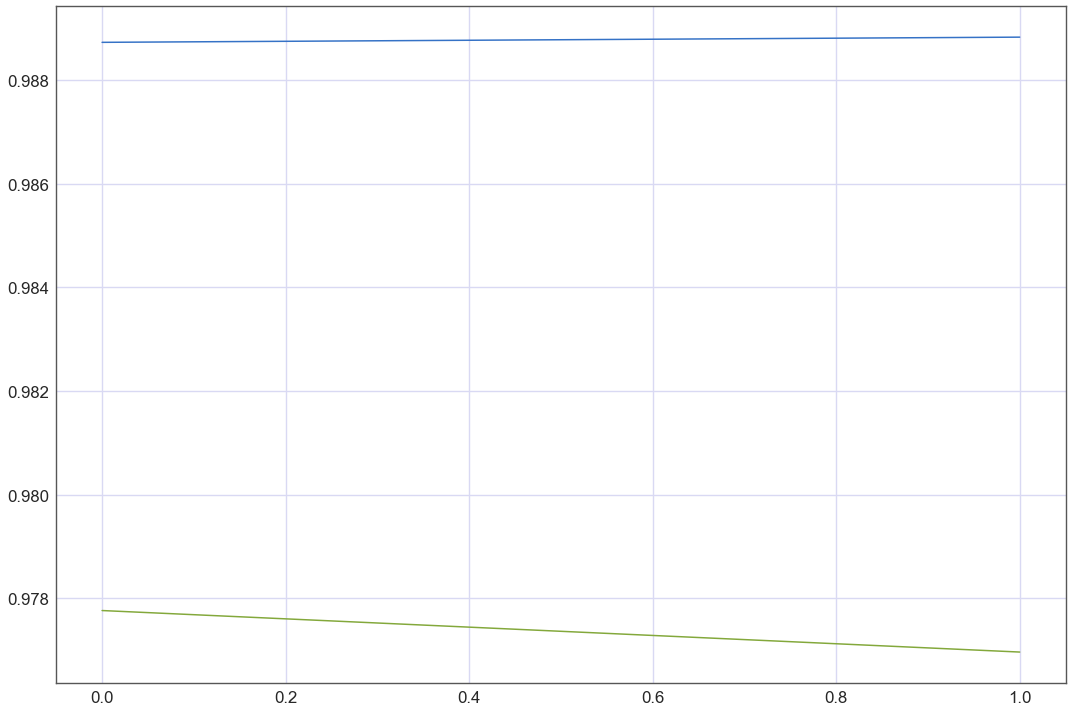

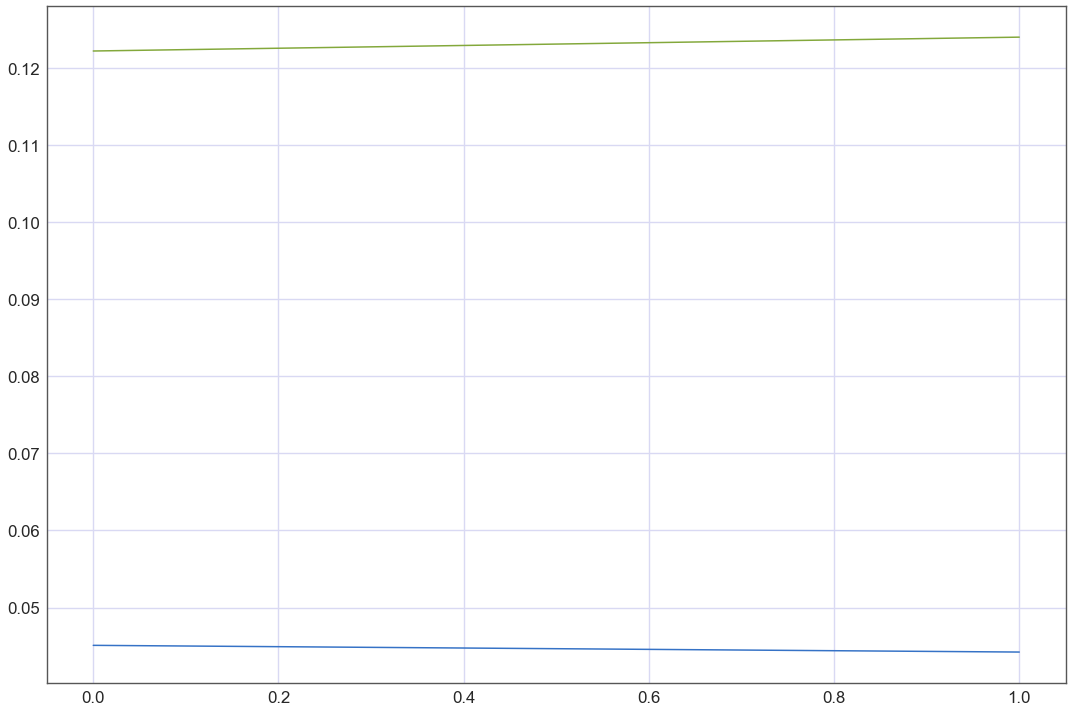

In [159]:
plot(hist.history['acc'])
plot(hist.history['val_acc'])
plt.show()
plot(hist.history['loss'])
plot(hist.history['val_loss'])

Save weights

In [114]:
model.save_weights(DIR_OUTPUT + '/resnet.h5')

# Find clip limits on validation set

In [127]:
val_preds = model.predict(val_features, batch_size=64, verbose=1)

4096/4992 [=======================>......] - ETA: 0s

In [128]:
def log_loss(y, y_hat):
    return -np.mean(y[:, 1] * np.log(y_hat[:, 1] + 1e-12) + (1 - y[:, 1]) * np.log(1 - y_hat[:, 1] + 1e-12))

In [146]:
high_losses = {}
low_losses = {}

for high in np.arange(0.5, 1.01, 0.01):
    high_losses[high] = log_loss(val_classes, np.clip(val_preds, 0, high))

for low in np.arange(0, 0.5, 0.01):
    low_losses[low] = log_loss(val_classes, np.clip(val_preds, low, 1))

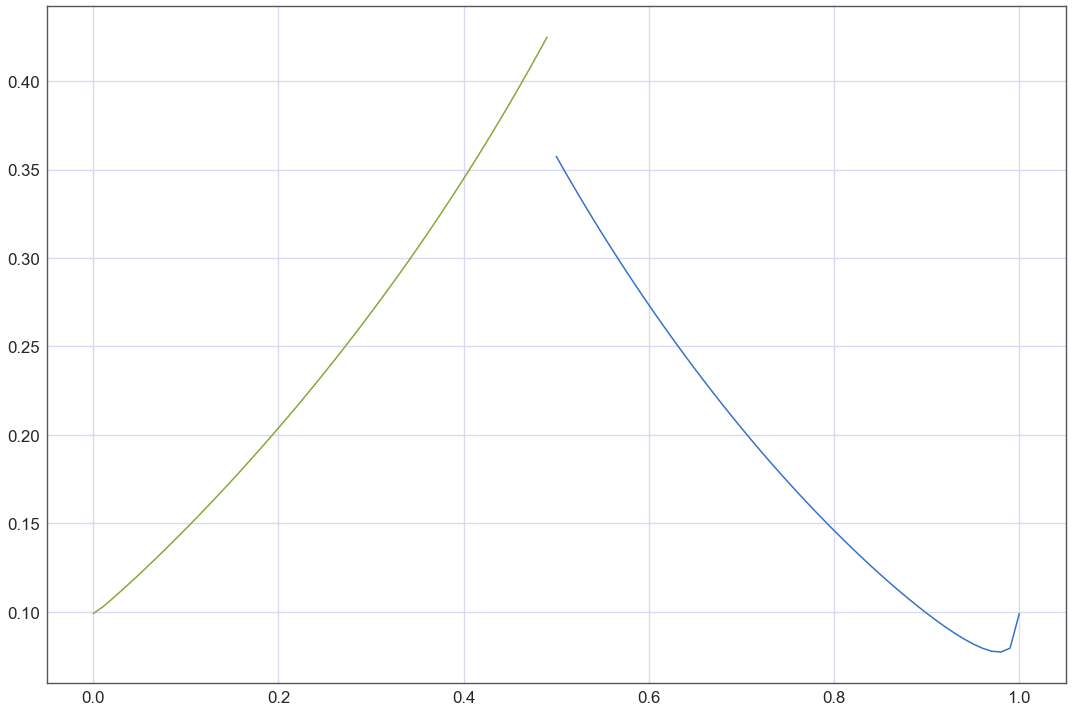

In [147]:
plot(list(high_losses.keys()), list(high_losses.values()))
plot(list(low_losses.keys()), list(low_losses.values()))

In [148]:
low_loss = list(low_losses.keys())[np.array(list(low_losses.values())).argsort()[0]]
high_loss = list(high_losses.keys())[np.array(list(high_losses.values())).argsort()[0]]

In [149]:
low_loss, high_loss

(0.0, 0.98000000000000043)

# Predict on Test Set

Get the predictions

In [150]:
preds = model.predict(test_features, batch_size=64, verbose=1)

 9792/12500 [======================>.......] - ETA: 0s

Get the IDs of the files (from the filenames)

In [151]:
ids = np.stack([int(filename[filename.find('/') + 1:filename.find('.')])
                for filename in test_batches.filenames])

Prepare the submissions

In [152]:
subm = np.stack([ids, preds[:, 1]], 1)
subm = subm[np.argsort(ids)]

Make a CSV of the predictions (in the Kaggle format)

In [153]:
with open(DIR_RESULTS + '/submission-resnet.csv', mode='w') as file:
    writer = CSVWriter(file)
    writer.writerow(('id', 'label'))
    for row in subm:
        writer.writerow((int(row[0]), np.clip(row[1], low_loss, high_loss)))